## 10-9. 프로젝트: CAM을 만들고 평가해 보자

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

#### 필요한 라이브러리와 데이터셋을 불러오고, GPU도 확인해 줍니다.

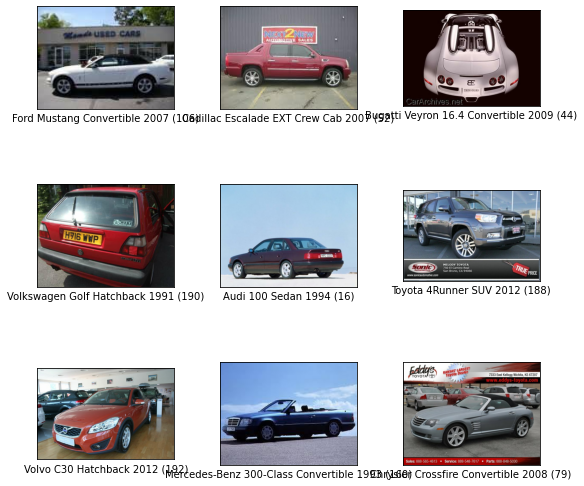

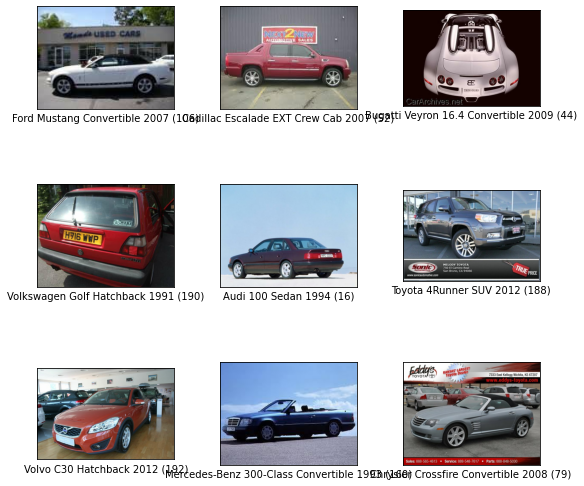

In [4]:
tfds.show_examples(ds_train, ds_info)

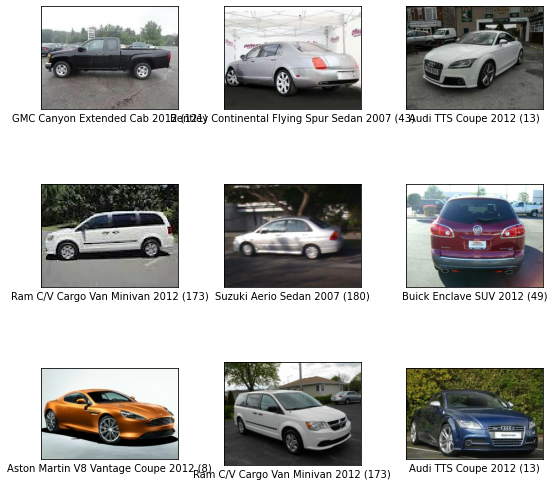

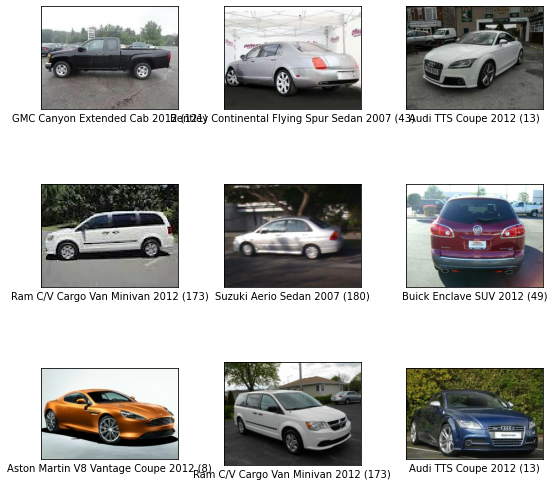

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

#### 학습용 데이터셋과 평가용데이터셋을 확인해보니 196종의 자동차 종류를 사진으로 판별하는 분류 데이터 셋입니다. image와 label즉 입력 이미지와 이미지에 해당하는 정답 클래스가 있고 bbox(바운딩 박스)도 포함되어 있습니다.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### CAM을 구하기 위한 기본 모델을 구성해봅니다.

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

#### 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리와 배치처리를 적용합니다.

In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 140s 206ms/step - loss: 4.9289 - accuracy: 0.0626 - val_loss: 5.4317 - val_accuracy: 0.0067
Epoch 2/15
509/509 [==============================] - 87s 172ms/step - loss: 2.0294 - accuracy: 0.5444 - val_loss: 1.8089 - val_accuracy: 0.5385
Epoch 3/15
509/509 [==============================] - 87s 172ms/step - loss: 0.7497 - accuracy: 0.8563 - val_loss: 1.2518 - val_accuracy: 0.6702
Epoch 4/15
509/509 [==============================] - 87s 171ms/step - loss: 0.2411 - accuracy: 0.9729 - val_loss: 1.1108 - val_accuracy: 0.7103
Epoch 5/15
509/509 [==============================] - 87s 171ms/step - loss: 0.0867 - accuracy: 0.9956 - val_loss: 1.0051 - val_accuracy: 0.7328
Epoch 6/15
509/509 [==============================] - 85s 168ms/step - loss: 0.0441 - accuracy: 0.9978 - val_loss: 0.9900 - val_accuracy: 0.7377
Epoch 7/15
509/509 [==============================] - 86s 169ms/step - loss: 0.0289 - accuracy: 0.9981 - val_loss: 0.9900 - val_a

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


#### 학습시키고 학습시킨 가중치를 저장해 줍니다.

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

### CAM 구현하기

58


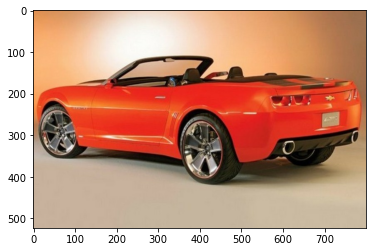

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [16]:
cam_model = tf.keras.models.load_model(cam_model_path)

####  CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 합니다.

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

#### generate_cam() 을 구현하기 위해 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize 해줍니다.

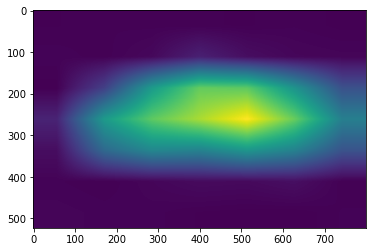

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

#### CAM을 확인해 봅니다.

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

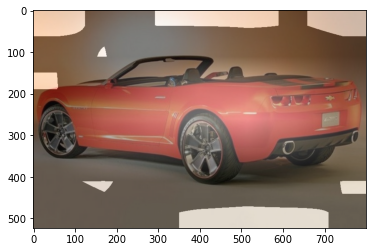

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

#### CAM 이미지를 원본 이미지와 합쳐 봅니다. 중요한 이미지를 잘 포착한 것인지 잘 모르겠네요^^;;

### Grad-CAM 구현하기

12


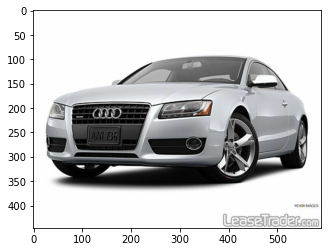

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

#### Grad-CAM을 이용해서 CAM을 얻어보겠습니다. 새로운 이미지를 하나 준비합니다.

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

#### grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 됩니다.

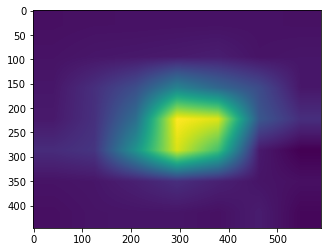

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

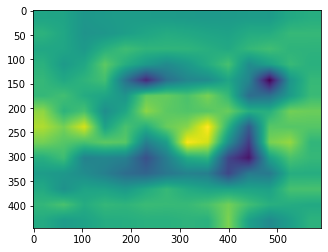

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

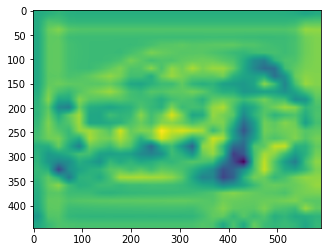

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

#### 몇개 레이어의 CAM 이미지를 뽑아서 직접 확인개 봅니다. 

### 바운딩 박스 구하기

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [30]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ -1, 402],
       [  1,  82],
       [801,  87],
       [798, 407]])

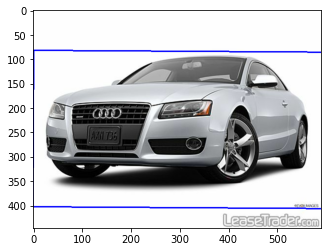

In [35]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

#### cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화해 봅니다.

In [36]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [37]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.18385650224215247,
 -0.001694915254237288,
 0.9125560538116592,
 1.3576271186440678]

In [38]:
item['bbox']

array([0.20403588, 0.04576271, 0.7847534 , 0.9542373 ], dtype=float32)

#### 위에서 구했던 rect를 minmax bbox 형태로 치환해  ground truth bbox를 확인해 봅니다.

### IoU 구하기

In [39]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [40]:
get_iou(pred_bbox, item['bbox'])

0.5326069583550722

#### CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 얼마나 유사한지 IoU를 계산해서 확인해 봅니다.

12


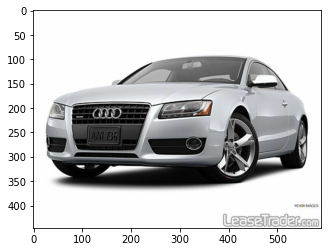

In [61]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

#### CAM과 Grad-CAM의 성능을 비교하기 위해 이미지를 하나 불러옵니다.

In [62]:
cam_image = generate_cam(cam_model, item)

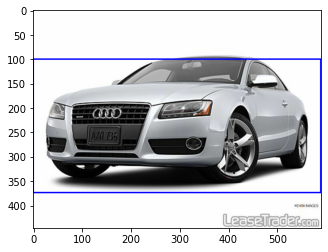

In [63]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [64]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['bbox'])

0.8090761563468253

#### 비교적 안정적으로 bbox가 그려진것을 확인 할수 있습니다. 

In [65]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)

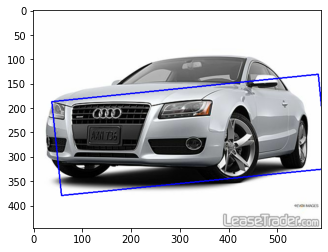

In [66]:
image = copy.deepcopy(item['image'])
rect_g = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect_g],0,(0,0,255),2)
plt.imshow(image)

In [67]:
pred_bbox = rect_to_minmax(rect_g, item['image'])
get_iou(pred_bbox, item['bbox'])

0.7011996394455196

#### 더 좋은 결과를 예상했던 Grad-CAM의 성능이 더 낮아보이네요^^;; 랜덤으로 이미지를 바꿔봐도 결과가 비슷하네요. 뭐가 잘못된 걸까요?

## 총평

### 더 많은 이미지를 테스트하면 결과가 조금은 달라질 수도 있을것 같은데 예상을 깨고 Grad-CAM의 성능이 떨어진다는 점이 조금 의아했습니다. 